<h1>Imports</h1>
Import libraries for pre-processing, feature selection, dimension reduction, model training and performance metrics.

In [1]:
import re, nltk, langid

import numpy as np
import pandas as pd
import mtranslate as mt
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from bs4 import BeautifulSoup

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import uniform, randint

nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/wal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/wal/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h1>Pipeline 1</h1>

<h2>Reading</h2>

Read tab seperated files and store them into dataframe.

In [2]:
mediaeval_train = pd.read_csv('mediaeval-2015-trainingset.txt', sep='\\t', engine='python')
mediaeval_test = pd.read_csv('mediaeval-2015-testset.txt', sep='\\t', engine='python')

<h2>Pre-Processing</h2>
Remove irrelevant features from both datasets.

In [3]:
def remove_columns(df):
    df.drop(['tweetId'], axis=1, inplace=True)
    df.drop(['userId'], axis=1, inplace=True)
    df.drop(['imageId(s)'], axis=1, inplace=True)
    df.drop(['username'], axis=1, inplace=True)
    df.drop(['timestamp'], axis=1, inplace=True)

remove_columns(mediaeval_train)
remove_columns(mediaeval_test)

Non-English tweets were originally translated from train set; however, this had a negative impact. So instead, only English tweets are retained in the dataset.

In [4]:
#tweets_texts = [mt.translate(tweet, 'en') for tweet in tweet_texts]

# translating from English is too computationally expensive and takes time
#tweet_texts = [tweet for tweet in tweet_texts if langid.classify(tweet)[0] == 'en']

is_english = lambda x: langid.classify(x)[0] == 'en' # classify language as english or not
mediaeval_train = mediaeval_train[mediaeval_train['tweetText'].apply(is_english)] # filter non-english tweets

All uppercase characters are converted into their lowercase counterpart.

In [5]:
def convert_to_lower(tweet_text):
    return tweet_text.lower()

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].map(convert_to_lower)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].map(convert_to_lower)

Next, the text needs to be cleaned of any invalid data that contributes to the noise of the dataset.

In [6]:
def clean_tweet(tweet_text):
    # remove html artefacts from text
    cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')

    # remove URLs
    cleaned_tweet = re.sub(r'http\S+', '', cleaned_tweet)
    cleaned_tweet = re.sub(r'\\(\S)*', '', cleaned_tweet)
    
    # remove non-ASCII characters (e.g. emojis)
    cleaned_tweet = re.sub(r'[^\x00-\x7F]+', '', cleaned_tweet)
    
    # remove twitter mentions
    cleaned_tweet = re.sub(r'@\w+', '', cleaned_tweet)

    return cleaned_tweet

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(clean_tweet)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(clean_tweet)

/var/folders/d3/pp72ynv541ncyrk24k0dw9wc0000gn/T/ipykernel_7250/882304478.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')
/var/folders/d3/pp72ynv541ncyrk24k0dw9wc0000gn/T/ipykernel_7250/882304478.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')


Remove punctuation.

In [7]:
def remove_punctuation(tweet_text):
    return re.sub(r'\s+', ' ', re.sub(r'(?![#@])[^a-zA-Z0-9\s]', '', tweet_text)).strip() # remove excess whitespace

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(remove_punctuation)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(remove_punctuation)

Attempt to detect the most popular languages and convert them only. This was considered but offered no improvement to performance. This maybe because the model became too tuned on a subset of languages and failed to generalise well against newer languages.

In [8]:
#def detect_language(tweet):
#    return langid.classify(tweet)[0]

#mediaeval_train['tweetLanguage'] = mediaeval_train['tweetText'].apply(detect_language)

#top_languages = mediaeval_train['tweetLanguage'].value_counts().head(10)

#print(top_languages)
#print(stopwords.fileids())

Stop words and twitter artefacts are to be eliminated from the text to reduce the dimensions of the matrix.

In [9]:
def remove_stopwords(tweet_text):
    stop_words = set()
    twitter_words = ['rt']
    
    languages = stopwords.fileids()

    # remove stopwords and twitter words from all languages available
    for lang in languages:
        stop_words.update(stopwords.words(lang))
    stop_words.update(set(twitter_words))
    
    tokens = word_tokenize(tweet_text)
    tweet_text = ' '.join([word for word in tokens if word not in stop_words])

    return tweet_text

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(remove_stopwords)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(remove_stopwords)

Remove duplicate rows from dataframes. This worsens performance as it may have reduced the size of the training data, preventing the model from generalising well on the test data. This is no longer used as a result.

In [10]:
#def remove_duplicates(df):
#    df.drop_duplicates(subset=['tweetText'], inplace=True)

# worsens f1 score significantly
#remove_duplicates(mediaeval_train)
#remove_duplicates(mediaeval_test)

Add pre-processed tweets to the dataframe and tweets labeled as <i>humor</i> will be converted into <i>fake</i>.

In [11]:
def convert_humour(df):
    df['label'] = df['label'].replace('humor', 'fake')
    return df
    
mediaeval_train = convert_humour(mediaeval_train)
mediaeval_test = convert_humour(mediaeval_test)

<h2>Model Training</h2>

In [12]:
# -------------      Parameter Grid      ------------- #
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
}

# -------------      Training & Testing Data      ------------- #
x_train, y_train = mediaeval_train['tweetText'], mediaeval_train['label']
x_test, y_test = mediaeval_test['tweetText'], mediaeval_test['label']

# encode labels into values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# -------------      Count Vectoriser      ------------- #
#vectoriser = CountVectorizer()

#x_train = vectoriser.fit_transform(x_train)
#x_test = vectoriser.transform(x_test)

# -------------      TF-IDF Vectoriser      ------------- #
tfidf_vectoriser = TfidfVectorizer()

x_train = tfidf_vectoriser.fit_transform(x_train)
x_test = tfidf_vectoriser.transform(x_test)

# -------------      Estimator       ------------- #
svc_classifier = SVC()

grid_search = GridSearchCV(svc_classifier, param_grid, cv=4, scoring='f1', n_jobs=-1)
grid_search.fit(x_train, y_train)

# obtain best parameters
best_params_svc = grid_search.best_params_

# -------------      Estimator       ------------- #
# took too long -> most likely due to ill-defined search space
#random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1')
#random_search.fit(x_test, y_test)

#print(random_search.best_estimator_.steps)

#best_params_tfidf = random_search.best_estimator_.named_steps['tfidf'].get_params()
#best_params_svc = random_search.best_estimator_.named_steps['svc'].get_params()

# -------------      TF-IDF Vectoriser      ------------- #
# experimented with hyperparameters, no substantial performance improvement
#tfidf_vectoriser = TfidfVectorizer(min_df=2, max_df=0.1, max_features=4700, ngram_range=(1,2))

#x_train = tfidf_vectoriser.fit_transform(x_train)
#x_test = tfidf_vectoriser.transform(x_test)

# -------------      Logistic Regression      ------------- #
#lr_classifier = LogisticRegression()

#lr_classifier.fit(x_train, y_train)
#y_pred = lr_classifier.predict(x_test)

# -------------      Support Vector Machine #1      ------------- #
#svc_classifier = SVC()

#svc_classifier.fit(x_train, y_train)
#y_pred = svc_classifier.predict(x_test)

# -------------      Support Vector Machine #2      ------------- #
svc_classifier = SVC(**best_params_svc)
svc_classifier.fit(x_train, y_train)

y_pred = svc_classifier.predict(x_test)

<h2>Evaluation</h2>

Accuracy: 0.7839195979899497
Precision: 0.8647181628392484
Recall: 0.8077223088923557
F1 Score: 0.8352490421455938


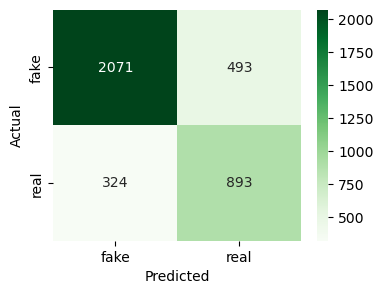

In [13]:
# decode values into labels
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)

# -------------      Evaluation      ------------- #
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='fake') # ensure positive class is 'fake'
recall = recall_score(y_test, y_pred, pos_label='fake')
f1 = f1_score(y_test, y_pred, pos_label='fake')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# -------------      Confusion Matrix      ------------- #
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', 
            xticklabels=['fake', 'real'],
            yticklabels=['fake', 'real'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h2>Results</h2>
<h3>Logistic Regression with Count Vectoriser</h3>
<ul>
    <li>Accuracy: 0.6760116371330336</li>
    <li>Precision: 0.7192924991811334</li>
    <li>Recall: 0.8564742589703588</li>
    <li>F1 Score: 0.7819120526971693</li>
</ul>
<h3>Support Vector Machine with Count Vectoriser</h3>
<ul>
    <li>Accuracy: 0.6553821740280349</li>
    <li>Precision: 0.6737393221273078</li>
    <li>Recall: 0.9535881435257411</li>
    <li>F1 Score: 0.7896011626029389</li>
</ul>
<h3>Support Vector Machine with Count Vectoriser (Grid Search)</h3>
<ul>
    <li>Accuracy: 0.6553821740280349</li>
    <li>Precision: 0.6737393221273078</li>
    <li>Recall: 0.9535881435257411</li>
    <li>F1 Score: 0.7896011626029389</li>
</ul>
<h3>Support Vector Machine with TF-IDF Vectoriser (Grid Search)</h3>
<ul>
    <li>Accuracy: 0.6474477651414969</li>
    <li>Precision: 0.6833482275841525</li>
    <li>Recall: 0.8946957878315133</li>
    <li>F1 Score: 0.7748691099476438</li>
</ul>
<h3>Support Vector Machine with TF-IDF Vectoriser (Grid Search, CV=4)</h3>
<ul>
    <li>Accuracy: 0.7839195979899497</li>
    <li>Precision: 0.8647181628392484</li>
    <li>Recall: 0.8077223088923557</li>
    <li>F1 Score: 0.8352490421455938</li>
</ul>

<h1>Pipeline 2</h1>

Read tab seperated files and store them into dataframe.

In [14]:
mediaeval_train = pd.read_csv('mediaeval-2015-trainingset.txt', sep='\\t', engine='python')
mediaeval_test = pd.read_csv('mediaeval-2015-testset.txt', sep='\\t', engine='python')

<h2>Pre-Processing</h2>

Next, the text needs to be cleaned of any invalid data that contributes to the noise of the dataset. Leaving mentions and only applying this to the training set improved performance. The model may have been able to generalise better as certain patterns may have occurred in fake tweets and real tweets pertaining to the use of mentions. Moreover, working under the assumption of applying pre-processing steps to both the training and test set has been detrimental, this may be due to the size of the training set or a higher prevalence of anomalies found within the test set (e.g. duplicate rows).

In [15]:
def clean_tweet(tweet_text):
    # remove html artefacts from text
    cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')

    # remove URLs
    cleaned_tweet = re.sub(r'http\S+', '', cleaned_tweet)
    cleaned_tweet = re.sub(r'\\(\S)*', '', cleaned_tweet)
    
    # remove non-ASCII characters
    cleaned_tweet = re.sub(r'[^\x00-\x7F]+', '', cleaned_tweet)
    
    # remove twitter mentions
    # cleaned_tweet = re.sub(r'@\w+', '', cleaned_tweet)

    return cleaned_tweet

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(clean_tweet)
#mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(clean_tweet)

/var/folders/d3/pp72ynv541ncyrk24k0dw9wc0000gn/T/ipykernel_7250/2754516690.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')
/var/folders/d3/pp72ynv541ncyrk24k0dw9wc0000gn/T/ipykernel_7250/2754516690.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  cleaned_tweet = BeautifulSoup(tweet_text, 'html.parser').get_text().replace('\\n', '')


Remove punctuation only from the training set.

In [16]:
def remove_punctuation(tweet_text):
    return re.sub(r'\s+', ' ', re.sub(r'(?![#@])[^a-zA-Z0-9\s]', '', tweet_text)).strip()

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(remove_punctuation)
#mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(remove_punctuation)

All uppercase characters are converted into their lowercase counterpart.

In [17]:
def convert_to_lower(tweet_text):
    return tweet_text.lower()

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].map(convert_to_lower)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].map(convert_to_lower)

Stop words and twitter artefacts are to be eliminated from the text to reduce the dimensions of the matrix.

In [18]:
tokeniser = TweetTokenizer()

def remove_stopwords(tweet_text):
    stop_words = set()
    twitter_words = ['rt']
    
    languages = stopwords.fileids()

    for lang in languages:
        stop_words.update(stopwords.words(lang))
    stop_words.update(set(twitter_words))
    
    tokens = tokeniser.tokenize(tweet_text)
    tweet_text = ' '.join([word for word in tokens if word not in stop_words])

    return tweet_text

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(remove_stopwords)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(remove_stopwords)

Stem all terms from each document present in the dataframes. 

In [19]:
porter = PorterStemmer()

def stem_words(tweet_text):
    tokens = tokeniser.tokenize(tweet_text)
    return ' '.join([porter.stem(word) for word in tokens])

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(stem_words)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(stem_words)

Lemmatise all terms from each document.

In [20]:
lemmatiser = WordNetLemmatizer()

def lemmatise_words(tweet_text):
    tokens = tokeniser.tokenize(tweet_text)
    return ' '.join([lemmatiser.lemmatize(word) for word in tokens])

mediaeval_train['tweetText'] = mediaeval_train['tweetText'].apply(lemmatise_words)
mediaeval_test['tweetText'] = mediaeval_test['tweetText'].apply(lemmatise_words)

Add pre-processed tweets to the dataframe and tweets labeled as <i>humor</i> will be converted into <i>fake</i>.

In [21]:
def convert_humour(df):
    df['label'] = df['label'].replace('humor', 'fake')
    return df
    
mediaeval_train = convert_humour(mediaeval_train)
mediaeval_test = convert_humour(mediaeval_test)

<h2>Model Training</h2>

In [22]:
# -------------      Training & Testing Data      ------------- #
x_train, y_train = mediaeval_train['tweetText'], mediaeval_train['label']
x_test, y_test = mediaeval_test['tweetText'], mediaeval_test['label']

# encode labels into values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# -------------      Parameter Distribution      ------------- #
knn_param_dist = {
    'n_neighbors': randint(1, 10),
    'p': [1, 2]
}

# -------------      TF-IDF Vectoriser      ------------- #
tfidf_vectoriser = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.1, max_features=4000, ngram_range=(1,2))
x_train = tfidf_vectoriser.fit_transform(x_train)
x_test = tfidf_vectoriser.transform(x_test)

# -------------      Estimator       ------------- #
# helped narrow down the best params for KNN
#knn_classifier = KNeighborsClassifier()

#random_search_knn = RandomizedSearchCV(knn_classifier, param_distributions=knn_param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1)
#random_search.fit(x_train, y_train)

#best_params_knn = random_search.best_estimator_.get_params()

#print(best_params_knn)

# -------------      Multinomial Naive Bayes      ------------- #
#mnb_classifier = MultinomialNB()
#mnb_classifier.fit(x_train, y_train)

#y_pred = mnb_classifier.predict(x_test)

# -------------      K-Nearest Neighbour      ------------- #
knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2)
knn_classifier.fit(x_train, y_train)

y_pred = knn_classifier.predict(x_test)

# -------------      Logistic Regression      ------------- #
#logistic_regression = LogisticRegression()
#logistic_regression.fit(x_train, y_train)

#y_pred = logistic_regression.predict(x_test)

# -------------      Stochastic Gradient Descent      ------------- #
#sgd_classifier = SGDClassifier()
#sgd_classifier.fit(x_train, y_train)

#y_pred = sgd_classifier.predict(x_test)

<h2>Evaluation</h2>

Accuracy: 0.8952658026976991
Precision: 0.8896477354421279
Recall: 0.9652886115444618
F1 Score: 0.9259259259259259


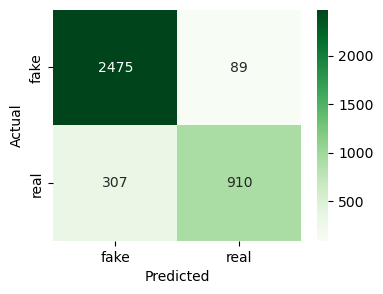

In [23]:
# decode values into labels
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)

# -------------      Evaluation      ------------- #
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='fake')
recall = recall_score(y_test, y_pred, pos_label='fake')
f1 = f1_score(y_test, y_pred, pos_label='fake')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# -------------      Confusion Matrix      ------------- #
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', 
            xticklabels=['fake', 'real'],
            yticklabels=['fake', 'real'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h2>Results</h2>
<h3>Multinomial Naive Bayes with TF-IDF Vectoriser</h3>
<ul>
    <li>Accuracy: 0.887595874107379</li>
    <li>Precision: 0.9049602423324499</li>
    <li>Recall: 0.9321372854914196</li>
    <li>F1 Score: 0.9183477425552354</li>
</ul>
<h3>K-Nearest Neighbours with TF-IDF Vectoriser</h3>
<ul>
    <li>Accuracy: 0.8952658026976991</li>
    <li>Precision: 0.8896477354421279</li>
    <li>Recall: 0.9652886115444618</li>
    <li>F1 Score: 0.9259259259259259</li>
</ul>
<h3>Logistic Regression with TF-IDF Vectoriser</h3>
<ul>
    <li>Accuracy: 0.8828352287754563</li>
    <li>Precision: 0.8955613577023499</li>
    <li>Recall: 0.9364274570982839</li>
    <li>F1 Score: 0.915538608198284</li>
</ul>
<h3>Stochastic Gradient Descent with TF-IDF Vectoriser</h3>
<ul>
    <li>Average Accuracy: 0.8816715154720974</li>
    <li>Average Precision: 0.8946228786721651</li>
    <li>Average Recall: 0.9357254290171605</li>
    <li>Average F1 Score: 0.9147108432643783</li>
</ul>